In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
import pickle

sns.set()
warnings.filterwarnings('ignore')

In [2]:
from sklearn.feature_selection import mutual_info_regression, SelectKBest, chi2
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, scale, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_absolute_percentage_error, mean_squared_error, roc_auc_score, log_loss, precision_recall_fscore_support, mean_absolute_error, roc_curve, auc, f1_score, make_scorer, precision_score, recall_score, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from imblearn.over_sampling import RandomOverSampler, SMOTE
from eli5.sklearn import PermutationImportance
from pprint import pprint

from xgboost import XGBRegressor, XGBClassifier

---

In [3]:
pd.set_option('display.max_columns', None)

---

## Load dataset

In [4]:
path = 'dataset/preprocessed_data.csv'
df = pd.read_csv(path)
df.shape

(372541, 40)

## Extra processing to remove all null entries

In [5]:
# print null percentages
print(df.isnull().mean() * 100)

BidsPortfolioManager                       0.000000
BidsApi                                    0.000000
BidsManual                                 0.000000
NewCreditCustomer                          0.000000
FirstPaymentDate                           0.000000
VerificationType                           0.013421
LanguageCode                               0.000000
Age                                        0.000000
Gender                                     0.012079
Country                                    0.000000
AppliedAmount                              0.000000
Amount                                     0.000000
Interest                                   0.000000
LoanDuration                               0.000000
MonthlyPayment                             1.795775
UseOfLoan                                 90.178799
Education                                  2.880757
MaritalStatus                             90.194368
EmploymentStatus                          90.241611
EmploymentDu

### this Rows containing nulls should be dropped in earlier steps but i kept them fo visualizations in EDA part lets remove them now

In [6]:
# if nulls in column are more than 50% then drop the column
null_val = (df.isnull().sum() / len(df))*100
missing_features = null_val[null_val > 40].index
missing_features

Index(['UseOfLoan', 'MaritalStatus', 'EmploymentStatus', 'OccupationArea'], dtype='object')

In [7]:
# drop this columns
df.drop(missing_features, axis=1, inplace=True)
df.shape

(372541, 36)

In [8]:
missing_categorical = df.select_dtypes(include='object').isnull().sum()
missing_numerical = df.select_dtypes(include='number').isnull().sum()

In [9]:
print(missing_categorical)
print(missing_numerical)

FirstPaymentDate                         0
VerificationType                        50
LanguageCode                             0
Gender                                  45
Country                                  0
Education                            10732
EmploymentDurationCurrentEmployer    10896
HomeOwnershipType                     1660
Rating                                2733
CreditScoreEsMicroL                  32400
dtype: int64
BidsPortfolioManager                           0
BidsApi                                        0
BidsManual                                     0
Age                                            0
AppliedAmount                                  0
Amount                                         0
Interest                                       0
LoanDuration                                   0
MonthlyPayment                              6690
IncomeTotal                                    0
ExistingLiabilities                            0
LiabilitiesTotal  

In [10]:
for col in missing_categorical.keys():
    df[col]= df[col].interpolate('ffill')
    df[col]= df[col].interpolate('bfill')
    
    
for col in missing_numerical.keys():
    mean=df[col].mean()
    print(mean)
    df[col].fillna(mean,inplace=True)

408.8715550771593
15.004781379767595
261.4787901637672
40.420839585441605
2638.498188722583
2563.610287221809
27.367614249169883
49.92229580099909
98.7738557226849
2148.176116722723
2.5957062444133667
406.14699168682114
0.06764087711151257
2.8049251122845913
44.13316222405373
11.32917182269871
1176.7143208143536
577.2213222587583
1296.7430302742516
1.811463836275394
3757.6481048831233
1180.613136994062
0.04580863720310956
0.3237737591298676


In [11]:
# save the dataset 
df.to_csv('dataset\preprocessed_2.csv', index=False)

In [12]:
print(df.shape)

(372541, 36)


---

In [13]:
X = df.copy()
y = df[['loanStatus']]

X.drop(['loanStatus'], axis=1, inplace=True)

---

In [14]:
X.drop(['FirstPaymentDate',], axis=1, inplace=True)

In [15]:
# split data into traindata,testdata
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [16]:
# handle categorical variables using one hot encoding
X = pd.get_dummies(X, drop_first=True)

# handle categorical variables using label encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for col in X.columns:
    if X[col].dtype == 'object':
        X[col] = le.fit_transform(X[col])
X.shape


(372541, 83)

In [17]:
# save trian data and test data



In [18]:
X.head()

,BidsPortfolioManager,BidsApi,BidsManual,NewCreditCustomer,Age,AppliedAmount,Amount,Interest,LoanDuration,MonthlyPayment,IncomeTotal,ExistingLiabilities,LiabilitiesTotal,RefinanceLiabilities,DebtToIncome,FreeCash,MonthlyPaymentDay,Restructured,PrincipalPaymentsMade,InterestAndPenaltyPaymentsMade,PrincipalBalance,NoOfPreviousLoansBeforeLoan,AmountOfPreviousLoansBeforeLoan,PreviousRepaymentsBeforeLoan,PreviousEarlyRepaymentsCountBeforeLoan,VerificationType_Income unverified,"VerificationType_Income unverified, cross-referenced by phone",VerificationType_Income verified,VerificationType_Not set,LanguageCode_8,LanguageCode_English,LanguageCode_Estonian,LanguageCode_Finnish,LanguageCode_German,LanguageCode_Other,LanguageCode_Russian,LanguageCode_Slovakian,LanguageCode_Spanish,Gender_Undefined,Gender_Woman,Country_Finland,Country_Netherlands,Country_Slovakia,Country_Spain,Education_Higher education,Education_Primary education,Education_Secondary Education,Education_Vocational education,EmploymentDurationCurrentEmployer_Other,EmploymentDurationCurrentEmployer_Retiree,EmploymentDurationCurrentEmployer_TrialPeriod,EmploymentDurationCurrentEmployer_UpTo1Year,EmploymentDurationCurrentEmployer_UpTo2Years,EmploymentDurationCurrentEmployer_UpTo3Years,EmploymentDurationCurrentEmployer_UpTo4Years,EmploymentDurationCurrentEmployer_UpTo5Years,HomeOwnershipType_Homeless,HomeOwnershipType_Joint tenant,HomeOwnershipType_Living with parents,HomeOwnershipType_Mortage,HomeOwnershipType_Other,HomeOwnershipType_Owner,HomeOwnershipType_Owner with encumbrance,"HomeOwnershipType_Tenant, pre-furnished property","HomeOwnershipType_Tenant, unfurnished property",HomeOwnershipType_joint ownership,Rating_AA,Rating_B,Rating_C,Rating_D,Rating_E,Rating_F,Rating_HR,CreditScoreEsMicroL_M1,CreditScoreEsMicroL_M10,CreditScoreEsMicroL_M2,CreditScoreEsMicroL_M3,CreditScoreEsMicroL_M4,CreditScoreEsMicroL_M5,CreditScoreEsMicroL_M6,CreditScoreEsMicroL_M7,CreditScoreEsMicroL_M8,CreditScoreEsMicroL_M9
0,11,0.0,88.0,False,27,3189.0,3189.0,35.48,60,115.34,900.0,0,0.00,0,0.00,0.00,7,False,721.65,1330.8600,2467.35,1.0,3402.0,1161.57,0.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,0,0.0,0.0,False,35,4146.0,4146.0,19.86,60,108.17,3100.0,0,0.00,0,0.00,0.00,3,True,272.34,493.8575,3873.66,1.0,518.0,525.21,0.0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,0,0.0,0.0,False,23,531.0,531.0,19.52,60,15.25,1700.0,0,0.00,0,0.00,0.00,23,False,5.52,5.0700,525.48,3.0,1593.0,631.35,0.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,970,1150.0,5.0,False,53,2125.0,2125.0,20.97,60,62.05,354.0,8,485.09,6,26.29,10.92,12,False,1026.77,1187.9100,0.00,1.0,500.0,590.95,0.0,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,0,0.0,0.0,False,43,414.0,414.0,19.89,108,6.65,1200.0,0,0.00,0,0.00,0.00,4,False,9.05,32.9175,404.95,5.0,11198.0,1176.

In [19]:
over = RandomOverSampler(random_state=0)
smote = SMOTE()

stdscaler = StandardScaler()
scaler = MinMaxScaler()

pca = PCA(n_components=20)

---

## classification

In [20]:
def plot_roc(y_test,preds,model):
    """ 
    Plot the ROC curve  

    Parameters
    ----------
    y_test : pandas.Series
        the true values that we will predict
    preds : numpy.ndarray
        the predicted values
    model : str
        the name of the model

    Return
    ------ 
    A plot of the roc curve for the given model 
    """
    fpr, tpr, thresh = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    print('roc_auc_score for {}: '.format(model), roc_auc_score(y_test, preds))
    plt.subplots(1, figsize=(10,10))
    plt.title('ROC curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [21]:
def plot_report(y_test, preds,targets = None):
    """ 
    Plot classification report 

    Parameters
    ----------
    y_test : pandas.Series
        the true values that we will predict
    preds : numpy.ndarray
        the predicted values
    target_names : list
        A list that contains the target classes names

    Return
    ------ 
    Classification report plot 
    """
    clf_report = classification_report(y_test,
                                       preds,
                                       target_names=targets,
                                       output_dict=True)
    sb.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True,cmap="Greens")

In [26]:
rob_scaler = StandardScaler()
for col in X.columns:
    X[col] = rob_scaler.fit_transform(X[col].values.reshape(-1,1))
    
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# save the train,test data
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# train.to_csv('dataset/preprocessed_train.csv', index=False)
# test.to_csv('dataset/preprocessed_test.csv', index=False)


# save sample of data
sample = train.sample(1000)
sample_test = test.sample(100)

sample.to_csv('dataset/mini_sample.csv', index=False)
sample_test.to_csv('dataset/mini_sample_test.csv', index=False)




## **train, test split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [ ]:
y_train.value_counts()

loanStatus
0             176409
1              84369
Name: count, dtype: int64

## Logistic Regression 

In [ ]:
log = LogisticRegression(C= 100, penalty= 'l2', solver='newton-cg')
log.fit(X_train, y_train)
preds = log.predict(X_test)
print('test accuracy = ', round(accuracy_score(y_test, preds)*100, 2), '%')

test accuracy =  83.9 %


roc_auc_score for Logistic Regression:  0.7847835979829004


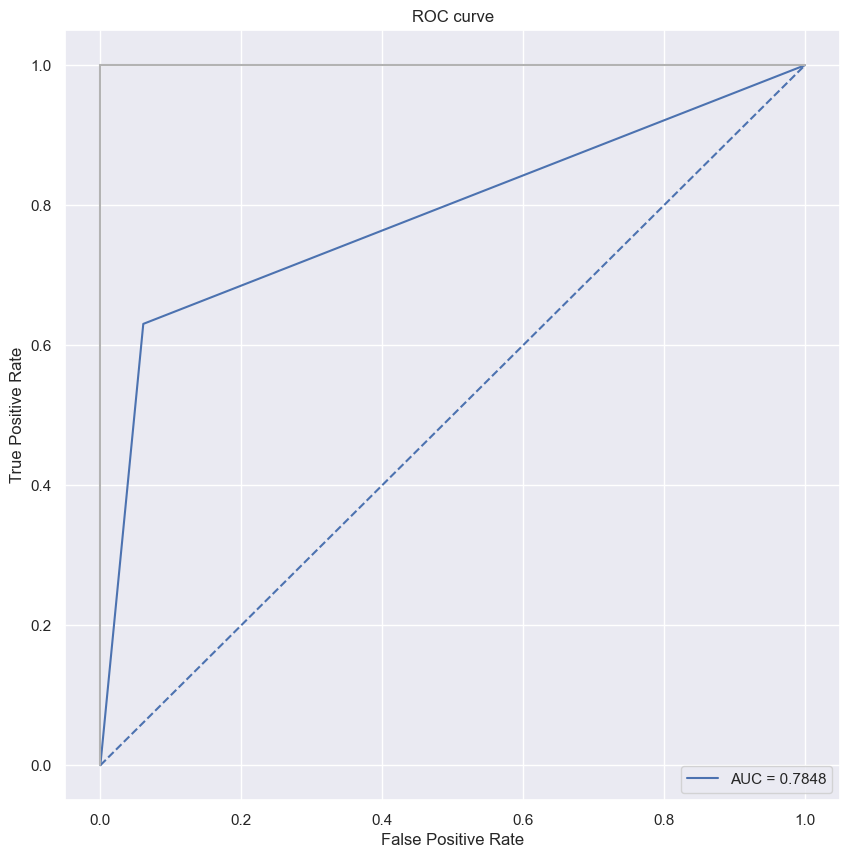

In [ ]:
plot_roc(y_test, preds, 'Logistic Regression')

## **Ensemble learning**

In [ ]:
qda = QuadraticDiscriminantAnalysis()

rf = RandomForestClassifier(random_state=0)

In [ ]:
estimators = [('QDA', qda), ('RandomForest', rf)]
final_estimator = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)

In [ ]:
model_ensemble = Pipeline([
    ('pca', pca),
    ('classifier', clf)
])

In [ ]:
model_ensemble.fit(X_train, y_train)
pred = model_ensemble.predict(X_test)
print('test accuracy = ', round(accuracy_score(y_test, pred)*100, 2), '%')

test accuracy =  79.17 %


roc_auc_score for ensemble model:  0.7267507342193191


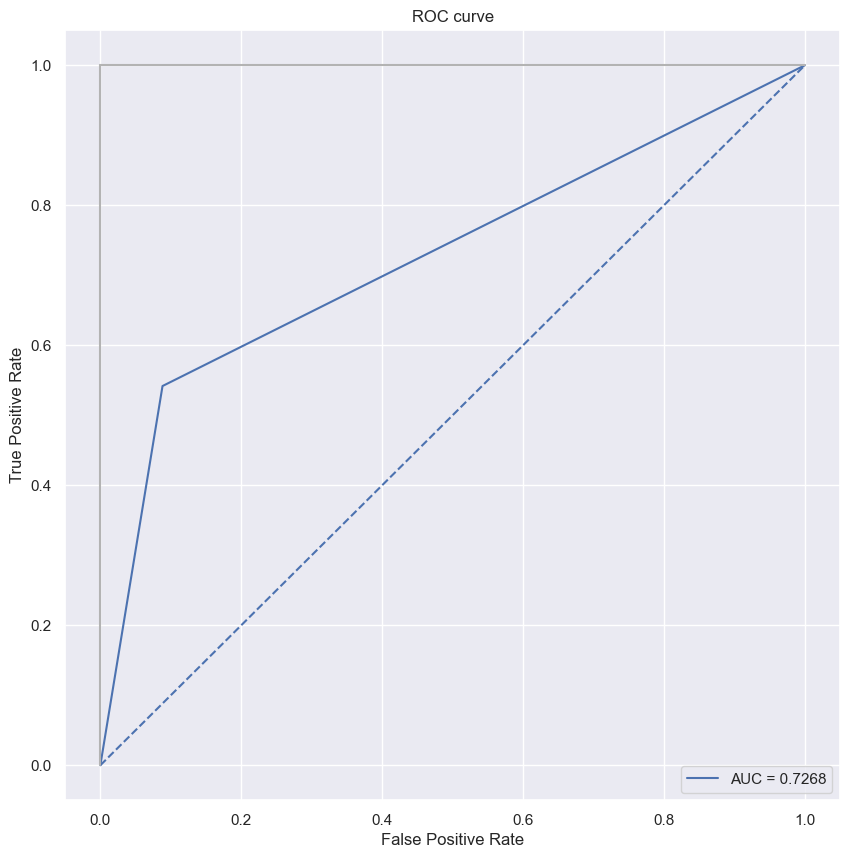

In [ ]:
plot_roc(y_test, pred, 'ensemble model')

In [ ]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.806     0.912     0.855     75513
           1      0.747     0.542     0.628     36250

    accuracy                          0.792    111763
   macro avg      0.776     0.727     0.742    111763
weighted avg      0.786     0.792     0.782    111763



**QDA**

In [ ]:
model_qda = Pipeline([
    ('classifier', qda)
])

In [ ]:
model_qda.fit(X_train, y_train)
pred = model_qda.predict(X_test)
print('test accuracy = ', round(accuracy_score(y_test, pred)*100, 2), '%')

test accuracy =  74.66 %


In [ ]:
print(classification_report(y_test, pred, digits=3))

              precision    recall  f1-score   support

           0      0.761     0.912     0.829     75513
           1      0.687     0.403     0.508     36250

    accuracy                          0.747    111763
   macro avg      0.724     0.657     0.668    111763
weighted avg      0.737     0.747     0.725    111763



**Random Forest**

In [ ]:
model_rf = Pipeline([
    ('pca', PCA(n_components=50)),
    ('classifier', rf)
])

In [ ]:
model_rf.fit(X_train, y_train)
pred = model_rf.predict(X_test)
print('test accuracy = ', round(accuracy_score(y_test, pred)*100, 2), '%')

test accuracy =  80.14 %


In [ ]:
print(classification_report(y_test, pred, digits=3))

---

## saving model

In [ ]:
pickle.dump(model_ensemble, open('../models/ensemble.pkl', 'wb'))
pickle.dump(model_qda, open('../models/qda.pkl', 'wb'))
pickle.dump(model_rf, open('../models/rf.pkl', 'wb'))

In [ ]:
# to load the model :
# pickled_model = pickle.load(open('model.pkl', 'rb'))
# pickled_model.predict(X_test)

---